In [216]:
import numpy as np

def life_step(X):
    live_neighbors = sum(np.roll(np.roll(X, i, 0), j, 1)
                     for i in (-1, 0, 1) for j in (-1, 0, 1)
                     if (i != 0 or j != 0))
    return (live_neighbors == 3) | (X & (live_neighbors == 2)).astype(int)

In [217]:
import matplotlib.pyplot as plt

def generate_frames(num_frames, board_shape=(100,100), prob_alive=0.15):
    return np.array([
        np.random.choice([False, True], size=board_shape, p=[1-prob_alive, prob_alive])
        for _ in range(num_frames)
    ]).astype(int)

def render_frames(frame1, frame2):
    plt.subplot(1, 2, 1)
    plt.imshow(frame1.flatten().reshape(board_shape), cmap='gray')

    plt.subplot(1, 2, 2)
    plt.imshow(frame2.flatten().reshape(board_shape), cmap='gray')

In [218]:
board_shape = (40, 40)
board_size = board_shape[0] * board_shape[1]
probability_alive = 0.15

frames = generate_frames(10, board_shape=board_shape, prob_alive=probability_alive)
print(frames.shape) # (num_frames, board_w, board_h)

(10, 40, 40)


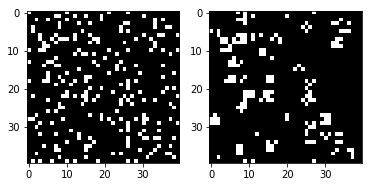

In [219]:
render_frames(frames[1], life_step(frames[1]))

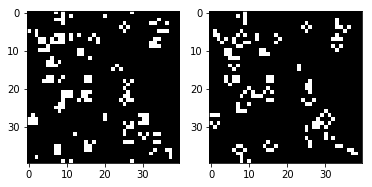

In [220]:
render_frames(life_step(frames[1]), life_step(life_step(frames[1])))

In [221]:
def reshape_input(X):
    return X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

def generate_dataset(num_frames, board_shape, prob_alive):
    X = generate_frames(num_frames, board_shape=board_shape, prob_alive=prob_alive)
    X = reshape_input(X)
    y = np.array([
        life_step(frame) 
        for frame in X
    ])
    return X, y

train_size = 70000
val_size   = 10000
test_size  = 20000

In [222]:
print("Training Set:")
X_train, y_train = generate_dataset(train_size, board_shape, probability_alive)
print(X_train.shape)
print(y_train.shape)

print("Validation Set:")
X_val, y_val = generate_dataset(val_size, board_shape, probability_alive)
print(X_val.shape)
print(y_val.shape)

print("Test Set:")
X_test, y_test = generate_dataset(test_size, board_shape, probability_alive)
print(X_test.shape)
print(y_test.shape)

Training Set:
(70000, 40, 40, 1)
(70000, 40, 40, 1)
Validation Set:
(10000, 40, 40, 1)
(10000, 40, 40, 1)
Test Set:
(20000, 40, 40, 1)
(20000, 40, 40, 1)


In [223]:
def pad_input(X):
    return reshape_input(np.array([
        np.pad(x.reshape(board_shape), (1,1), mode='wrap')
        for x in X
    ]))

X_train_padded = pad_input(X_train)
X_val_padded = pad_input(X_val)
X_test_padded = pad_input(X_test)

print(X_train_padded.shape)
print(X_val_padded.shape)
print(X_test_padded.shape)

(70000, 42, 42, 1)
(10000, 42, 42, 1)
(20000, 42, 42, 1)


In [224]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D


def my_model(filters, hidden_dims):
    # CNN Properties
    kernel_size = (3, 3) # look at all 8 neighboring cells, plus itself
    strides = 1
    
    model = Sequential()
    model.add(Conv2D(filters, kernel_size,padding='valid', activation='relu',
                     strides=strides, input_shape=(board_shape[0] + 2, board_shape[1] + 2, 1)))
    # model.add(Dense(hidden_dims, input_shape=(20,20, 1)))
    model.add(Dense(hidden_dims))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [230]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 20, 20, 60)        600       
_________________________________________________________________
dense_29 (Dense)             (None, 20, 20, 20)        1220      
_________________________________________________________________
dense_30 (Dense)             (None, 20, 20, 1)         21        
_________________________________________________________________
activation_15 (Activation)   (None, 20, 20, 1)         0         
Total params: 1,841
Trainable params: 1,841
Non-trainable params: 0
_________________________________________________________________


In [226]:
def train(model, X_train, y_train, X_val, y_val, batch_size=50, epochs=2, filename_suffix=''):
    model.fit(
        X_train, y_train, 
        batch_size=batch_size, 
        epochs=epochs,
        validation_data=(X_val, y_val)
    )
    
    res = model.evaluate(X_val, y_val)
    
    with open('cgol_cnn{}.json'.format(filename_suffix), 'w') as file:
        file.write(model.to_json())
    model.save_weights('cgol_cnn{}.h5'.format(filename_suffix))
    
    return res
    
def estimate(filters, hidden_dims, X_train, y_train, X_val, y_val):
    model = my_model(filters, hidden_dims)
    res = train(model, X_train_padded, y_train, X_val_padded, y_val, filename_suffix='_basic')
    
    return res[0], res[1]

# estimate(50, 30, X_train_padded, y_train, X_val_padded, y_val)

In [212]:
def grid_search():
    filters = np.arange(1, 10, 2)
    hidden_dims = np.arange(1, 10, 2)
    
    res = {}
    for f in filters:
        res.update({f:{}})
        for h in hidden_dims:
            val, acc = estimate(f, h, X_train_padded, y_train, X_val_padded, y_val)
            
            res[f].update({h:[val, acc]})
            
            print(f, h, ':', val, acc)
    
    return res

In [229]:
estimate(9, 20, X_train_padded, y_train, X_val_padded, y_val)

Train on 70000 samples, validate on 10000 samples
Epoch 1/2
70000/70000 [==============================] - 67s 952us/step - loss: 0.1498 - acc: 0.9544 - val_loss: 0.0428 - val_acc: 0.9896
Epoch 2/2
10000/10000 [==============================] - 3s 344us/step


(0.0023953153271228074, 1.0)

In [213]:
res = grid_search()

Train on 70000 samples, validate on 10000 samples
Epoch 1/2
70000/70000 [==============================] - 18s 263us/step - loss: 0.3534 - acc: 0.8804 - val_loss: 0.1837 - val_acc: 0.8794
Epoch 2/2
10000/10000 [==============================] - 1s 139us/step
1 1 : 0.07025682343244552 0.9783042507171631
Train on 70000 samples, validate on 10000 samples
Epoch 1/2
70000/70000 [==============================] - 19s 273us/step - loss: 0.3316 - acc: 0.8778 - val_loss: 0.1733 - val_acc: 0.9770
Epoch 2/2
10000/10000 [==============================] - 2s 162us/step
1 3 : 0.16701641466617584 0.9783042507171631
Train on 70000 samples, validate on 10000 samples
Epoch 1/2
70000/70000 [==============================] - 23s 326us/step - loss: 0.3150 - acc: 0.8870 - val_loss: 0.0911 - val_acc: 0.9783
Epoch 2/2
10000/10000 [==============================] - 2s 160us/step
1 5 : 0.06181765547990799 0.9783042507171631
Train on 70000 samples, validate on 10000 samples
Epoch 1/2
70000/70000 [===============

70000/70000 [==============================] - 26s 368us/step - loss: 0.2027 - acc: 0.9305 - val_loss: 0.1099 - val_acc: 0.9667
Epoch 2/2
10000/10000 [==============================] - 2s 191us/step
7 9 : 0.014780740639567375 0.9999152490615845
Train on 70000 samples, validate on 10000 samples
Epoch 1/2
70000/70000 [==============================] - 26s 365us/step - loss: 0.2212 - acc: 0.9066 - val_loss: 0.0830 - val_acc: 0.9783
Epoch 2/2
10000/10000 [==============================] - 1s 148us/step
9 1 : 0.061500451135635376 0.9783042507171631
Train on 70000 samples, validate on 10000 samples
Epoch 1/2
70000/70000 [==============================] - 27s 391us/step - loss: 0.2252 - acc: 0.9216 - val_loss: 0.1532 - val_acc: 0.9449
Epoch 2/2
10000/10000 [==============================] - 2s 169us/step
9 3 : 0.1472639236688614 0.9493042505264282
Train on 70000 samples, validate on 10000 samples
Epoch 1/2
70000/70000 [==============================] - 21s 301us/step - loss: 0.2069 - acc: 0.9

In [214]:
import matplotlib.pyplot as plt

def draw(res):
    new_res = np.empty((len(res.keys()), len(res[list(res.keys())[0]].keys())), dtype=np.float32)
    
    y, x = np.mgrid[1:10:2,1:10:2]
    for i, f in enumerate(res.keys()):
        for j, h in enumerate(res[f].keys()):
            new_res[i, j] = res[f][h][1]
            
    fig, ax = plt.subplots()
    
    cs = ax.pcolor(x, y, new_res, vmin=new_res.min(), vmax=1.0)
    ax.set_xlabel('hidden dims')
    ax.set_ylabel('filters')
    plt.title('Accuracy')
    cbar = fig.colorbar(cs)
    # fig.tight_layout()
    plt.show()


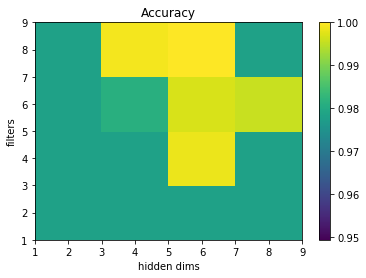

In [215]:
draw(res)

In [211]:
print(res)

{10: {10: [0.0049917268142104145, 1.0], 20: [0.002323041494935751, 1.0], 30: [0.0006739855738356709, 1.0], 40: [0.0005032760108821094, 1.0], 50: [0.00034669535225257276, 1.0], 60: [0.0005449361698701978, 1.0], 70: [0.00028751354929991066, 1.0]}, 20: {10: [0.0016713927645236255, 1.0], 20: [0.0006145367758348584, 1.0], 30: [0.0003186515621840954, 1.0], 40: [0.00028205871456302704, 1.0], 50: [0.0001892646566964686, 1.0], 60: [0.0001261173101840541, 1.0], 70: [0.00019986197506077587, 1.0]}, 30: {10: [0.0008309941967949271, 1.0], 20: [0.0003701884916052222, 1.0], 30: [0.00020127752975095063, 1.0], 40: [0.0001387106815353036, 1.0], 50: [8.86993563733995e-05, 1.0], 60: [0.00014200717804487795, 1.0], 70: [6.831289367983118e-05, 1.0]}, 40: {10: [0.0006441972935572267, 1.0], 20: [0.00020324618306476623, 1.0], 30: [0.00016875174762681126, 1.0], 40: [8.574107133317739e-05, 1.0], 50: [0.00012050596408080309, 1.0], 60: [0.00011112134053837508, 1.0], 70: [0.00010123330593341961, 1.0]}, 50: {10: [0.00

In [137]:
arr.shape

(2, 5, 4)